3000


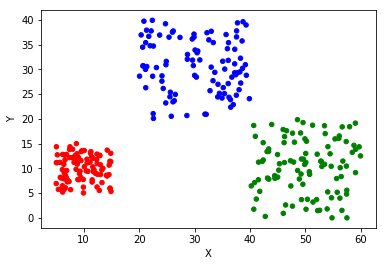

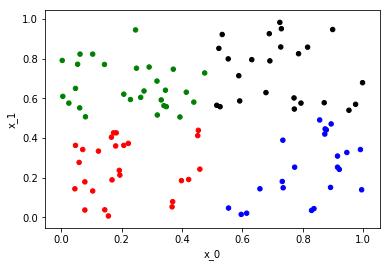

In [29]:
from anytree import Node, RenderTree, PreOrderIter
import anytree
import random
import pandas as pd
import numpy as np
import copy



import seaborn as sns
import matplotlib.pyplot as plt
import sys
print(sys.getrecursionlimit())
%matplotlib inline

# creates a data frame from a list of lists
def to_data_frame(data, feature_names):
    return pd.DataFrame(data, columns = feature_names)

#split data into decision sets
def split_data(dataFrame, feature, operator, value):
    try:
        leftDataFrame = dataFrame.query('{feature} {operator} {value}'.format(feature = feature, operator = operator, value = str(value))).reset_index(drop=True)
        rightDataFrame = dataFrame.query('~({feature} {operator} {value})'.format(feature = feature, operator = operator, value = str(value))).reset_index(drop=True)
        return leftDataFrame, rightDataFrame
    except Exception as e:
        print(e,get_features(dataFrame), feature, operator, value)
        return pd.DataFrame(), pd.DataFrame()

# gets all features of the dataset, removing class
def get_features(dataFrame):
    features = []
    for column in dataFrame.columns:
        if column != "Class":
            features.append(column)
    return features

# Gets classes that are available in a data frame
def get_classes(dataFrame):
    return dataFrame["Class"].unique()

# untested
def get_classes_multi(dataFrame, *dataFrames):
    combinedDataFrame = reduce(lambda left,right: pd.merge(left,right,on='name'), [dataFrame] + [dataFrames])
    return get_classes(combinedDataFrame)
    


def single_quadrant(classes, n, d):
    data_points = []
    for i in range(0,n):
        newClass = np.random.binomial(1,0.75)
        new_data_point = []
        if(newClass == 0):
            # x axis
            new_data_point.append(np.random.uniform(0,0.5,1)[0].round(3))
            # y axis
            new_data_point.append(np.random.uniform(0,0.5,1)[0].round(3))
                
        else:
            new_data_point.append(np.random.uniform(0,1,1)[0].round(3))
            if(new_data_point[0] <= 0.5):
                new_data_point.append(np.random.uniform(.51,1,1)[0].round(3))
            else:
                new_data_point.append(np.random.uniform(0,1,1)[0].round(3))
        new_data_point += [1 for i in range(0,d-2)]
        new_data_point.append(newClass)
        data_points.append(new_data_point)
    return data_points

def multi_quadrant(n, d):
    data_points = []
    for i in range(0,n):
        newClass = random.randint(0,3)
        new_data_point = []
        new_data_point.append(round(np.random.uniform((newClass % 2)/2,(newClass % 2)/2+ 0.5),3))
        # y axis
        new_data_point.append(round(np.random.uniform((newClass // 2)/2,(newClass // 2)/2 + 0.5),3))
        new_data_point += [1 for i in range(0,d-2)]
        new_data_point.append(newClass)
        data_points.append(new_data_point)
    return data_points


n = 100
d = 3
simulated = multi_quadrant(n,d)
simulatedData = to_data_frame(simulated, ["x_{n}".format(n = n) for n in range(0,d)]+["Class"])
test_data = pd.read_csv('Iris.csv')
del test_data["Id"]
test_data.rename(columns={'Species': 'Class'},inplace="True")
#test_data.plot(x="SepalLengthCm",y="SepalWidthCm", hue="Species",kind="scatter")
#plt.show()     

def cluster_data(clusters, n):
    data = []
    for cluster in clusters:
        for i in range(n):
            point = []
            for feature in cluster[1]:
                point.append(np.random.uniform(feature - cluster[2],feature + cluster[2]))
            point.append(cluster[0])
            data.append(point)
    return data
        #x1 = np.random.uniform(center1[0], center1[0] + distance, size=(100,))
        #y1 = np.random.normal(center1[1], distance, size=(100,)) 
cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'black'}
clusterdict = {"A": 'red', "B": 'blue', "C": 'green'}
clusters = [["A", [10,10],5],["B",[30,30],10],["C",[50,10],10]]
clusterData = cluster_data(clusters, n)
clusterDataFrame = to_data_frame(clusterData,['X','Y',"Class"])
clusterDataFrame.plot.scatter(x='X',y='Y',c=clusterDataFrame["Class"].map(clusterdict))   


simulatedData.plot.scatter(x='x_0',y='x_1',c=simulatedData["Class"].map(cdict)) 

In [30]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
X, y = simulatedData.drop(simulatedData.columns[len(simulatedData.columns)-1], axis=1, inplace=False),simulatedData["Class"]

Wall time: 105 ms


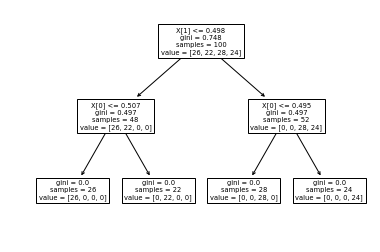

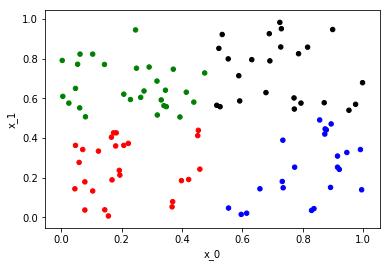

In [31]:
%%time
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
tree.plot_tree(clf)
simulatedData.plot.scatter(x='x_0',y='x_1',c=simulatedData["Class"].map(cdict)) 

In [85]:
# Calculates the error of a dataframe given a target class
def calculate_combined_error(dataFrame, targetClass):
    return len(dataFrame.query("Class != @targetClass").index)

# Calculates the error of a dataframe using the most popular class
def popular_error(dataFrame):
    return calculate_combined_error(dataFrame, dataFrame["Class"].value_counts().first_valid_index())

# Calculates the error value of how well the tree fits the data
# Input: Tree, Dataframe
# Recursive function
def error_value(tree, dataFrame):
    # misclassification error
    error = 0
    if not tree.is_leaf:
        
        # split data by decision
        feature, operator, value = tree.name.split()
        leftData,rightData  = split_data(dataFrame, feature, operator, value)
        # recure through left and right nodes
        if((not leftData.empty) and not tree.children[0].right):
            error += error_value(tree.children[0],leftData)
        if((not rightData.empty) and len(tree.children)>1):
            error += error_value(tree.children[1],rightData)
        elif((not rightData.empty) and tree.children[0].right):
            error += error_value(tree.children[0],rightData)
    else:
        error = len(dataFrame.query("Class != '{treeClass}'".format(treeClass = tree.Class)).index)
        
    return error



# Calculates the penalizing value for the complexity of the tree
# Input: Tree
# Recursive function
def complexity(tree):
    length = 0
    if not tree.is_leaf:
        # increase complexity by number of splits in the tree
        length += 1
        for child in tree.children:
            length += complexity(child)
    return length


# calculates the loss function for the tree and the respective data
def loss_function(tree, dataFrame, alpha = 0.5,baseLineError = 1):
    if baseLineError <= 0:
        baseLineError = 1
    return (1/baseLineError) * error_value(tree, dataFrame) + alpha * complexity(tree)

# calculates the loss function for the tree and the respective data
def dict_loss_function(tree, error_dict, alpha = 0.5,baseLineError = 1):
    if baseLineError <= 0:
        baseLineError = 1
    return (1/baseLineError) * get_dict_error(error_dict) + alpha * complexity(tree)

In [86]:
def check_features(dataFrame, features, printErrors = False):
    if(printErrors):
        print(*(("Error", feature, " not in list") for feature in features if feature not in get_features(dataFrame)), sep='\n')
    if features:
        return [feature for feature in features if feature in get_features(dataFrame)]
    else:
        return []

#def check_splits(dataframe, n_min):
    #if len(dataFrame.index) > n_min * 2
    # and either 
    #     2 n_min unique values
    #     n_min <= 2 and 2 unique sets of duplicates
    #     n_min > 2 and bin packing 
    #elif unique values are 
    #

# Create a leaf
# Uses most populous class in available data frame
def create_leaf(dataFrame,parent=None,right=False):
    
    if not dataFrame.empty:
        
        # Get the most populous class
        Class = dataFrame['Class'].value_counts().first_valid_index()

        # Get accuracy of class
        accuracy = (dataFrame['Class'].value_counts().iloc[0]/len(dataFrame.index)).round(3)
        error = calculate_combined_error(dataFrame, Class)
        size = len(dataFrame.index)
        
        # Create Node using parent node
        leaf = Node("class = {Class}, accuracy = {accuracy}, size = {size} error = {error}".format(Class=Class,accuracy=accuracy,size = size, error = error),parent=parent, Class = Class, accuracy = accuracy, error = error,size = size, right = right, checked = False)

        return leaf
    else:
        return None
    
# recursive function for creating random trees
def random_tree(dataFrame, features = None, parent = None, remainingDepth = 0, right = False, operators = ["<"], n_min = 1):
    if(n_min < 1):
        n_min = 1
    # create node with splits
    if(remainingDepth > 0 and len(dataFrame.index) >= n_min * 2):
        features = check_features(dataFrame,features)
        if not features or len(features) == 0:
            features = get_features(dataFrame)
        
        # Add check to ensure that a split is even possible, points may share same values
        leftDataFrame, rightDataFrame = pd.DataFrame(), pd.DataFrame()
        # Restrict possible dataframes by minimum data points
        while len(leftDataFrame.index) < n_min or len(rightDataFrame.index) < n_min:
            # split decision
            ############################################
            # Pick random feature and operator
            feature, operator = random.choice(features), random.choice(operators)
            # Choose random value in available feature
            value = random.choice(dataFrame[feature])
            ############################################
            

            # Split dataset on decision
            leftDataFrame, rightDataFrame = split_data(dataFrame, feature, operator, value)
            
        # Create decision node
        tree = Node('{feature} {operator} {value}'.format(feature = feature,operator = operator,value = value),parent = parent, right = right, checked = False)
        
        # create child nodes of decision node
        random_tree(leftDataFrame,features,tree,remainingDepth=remainingDepth-1,right=False, operators=operators, n_min = n_min)
        random_tree(rightDataFrame,features,tree,remainingDepth=remainingDepth-1,right=True, operators=operators, n_min = n_min)
    # Create a class node when at max length or no possible splits remaining
    else:
        # create leaf
        tree = create_leaf(dataFrame, parent, right)
    return tree

# prints the tree in ascii
def print_tree(tree):
    for pre, fill, node in RenderTree(tree):
        print("%s%s, %s, %s" % (pre, node.name,"Left" if not node.right else "Right", node.checked))

In [122]:
# Trims the dataset to appropriate data for the node
# Recurses from bottom to top
def data_values(node, dataFrame,right = None):
    
    # trim data starting from parent value
    if node.parent:
        dataFrame = data_values(node.parent,dataFrame,node.right)
        
    # if data is being split at node and the node has a split
    # Split data according to next node direction
    if right != None and node.children:
        
        feature, operator, value = node.name.split()
        return split_data(dataFrame, feature, operator, value)[int(right)]
    # If leaf or not splitting data at node
    # Return data at that node
    else:
        return dataFrame

# Verifies if all leaves in a tree have the minimum amount of data points
def verify_minimum_leaves(tree, n_min = 1):
    truth = True
    if tree.is_leaf:
        if tree.size < n_min:
            truth = False
    else:
        for child in tree.children:
            truth = truth == verify_minimum_leaves(child, n_min)
    
    return truth

############################################################

# Gets list of leaves of tree
def get_leaves(tree):
    leaves = []
    if not tree.is_leaf:
        for children in tree.children:
            leaves += get_leaves(children)
    else:
        leaves.append(tree)
    return leaves

# Creates dictionary of hashed leaves with values of 0
# Used for abstraction of leaves
def leaves_to_dict(tree):
    leaf_dict = {}
    leaves = get_leaves(tree)
    for leaf in leaves:
        leaf_dict[hash(leaf)] = 0
    return leaf_dict

#  Updates hashed leaf dictionary with data
def put_leaf_dict_data(tree, dataFrame, leafDict):
    # Update children of tree
    if not tree.is_leaf:
        
        # Get new data split for child nodes
        feature, operator, value = tree.name.split()
        leftData,rightData  = split_data(dataFrame, feature, operator, value)
        # Recure through all children
        if((not leftData.empty) and not tree.children[0].right):
            put_leaf_dict_data(tree.children[0],leftData,leafDict)
        if((not rightData.empty) and len(tree.children)>1):
            put_leaf_dict_data(tree.children[1],rightData,leafDict)
        elif((not rightData.empty) and tree.children[0].right):
            put_leaf_dict_data(tree.children[0],rightData,leafDict)
    else:
        leafDict[hash(tree)] = dataFrame['Class'].value_counts()

# Removes data values from hashed leaf dictionary
def minus_leaf_dict_data(tree, dataFrame, leafDict):
    # Update children of tree
    if not tree.is_leaf:
        
        # Get new data split for child nodes
        feature, operator, value = tree.name.split()
        leftData,rightData  = split_data(dataFrame, feature, operator, value)
        # Recure through all children
        if((not leftData.empty) and not tree.children[0].right):
            minus_leaf_dict_data(tree.children[0],leftData,leafDict)
        if((not rightData.empty) and len(tree.children)>1):
            minus_leaf_dict_data(tree.children[1],rightData,leafDict)
        elif((not rightData.empty) and tree.children[0].right):
            minus_leaf_dict_data(tree.children[0],rightData,leafDict)
    else:
        leafDict[hash(tree)] = leafDict[hash(tree)].subtract(dataFrame['Class'].value_counts(),fill_value = 0).sort_values(ascending = False)

# Adds data values to hashed leaf dictionary        
def plus_leaf_dict_data(tree, dataFrame, leafDict):
    # Update children of tree
    if not tree.is_leaf:
        
        # Get new data split for child nodes
        feature, operator, value = tree.name.split()
        leftData,rightData  = split_data(dataFrame, feature, operator, value)
        # Recure through all children
        if((not leftData.empty) and not tree.children[0].right):
            plus_leaf_dict_data(tree.children[0],leftData,leafDict)
        if((not rightData.empty) and len(tree.children)>1):
            plus_leaf_dict_data(tree.children[1],rightData,leafDict)
        elif((not rightData.empty) and tree.children[0].right):
            plus_leaf_dict_data(tree.children[0],rightData,leafDict)
    else:
        leafDict[hash(tree)] = dataFrame['Class'].value_counts().add(leafDict[hash(tree)],fill_value = 0).sort_values(ascending = False)

# Gets error of a sorted series (using most popular class)
def series_error(series):
    return series.sum() -  series.iloc[0] 

# Outputs error of series
def check_dict_error(item):
    if type(item) == pd.Series:
        return series_error(item)
    else:
        return 0

# Gets error of a hashed leaf dictionary
def get_dict_error(leafDict):
    error = 0
    for key in leafDict.keys():
        error += check_dict_error(leafDict[key])
    return error

# Debugging function for error of a hashed leaf dictionary
def get_each_dict_error(leafDict):
    for key in leafDict.keys():
        print(leafDict[key])
        print(check_dict_error(leafDict[key]))

# Exhaustively finds the local optimal data split of a node while keeping it's children
def optimal_node_data_split_dict(node, dataFrame, alpha = 0.5, baseLineError = 1, n_min = 1): 
    # Gets 
    childNodes = [copy.deepcopy(childNode) for childNode in node.children]
    bestError = [calculate_baseline_error(dataFrame),"","",""]
    tree_dict = leaves_to_dict(node)
    if(len(childNodes) != 1):
        if(len(childNodes) == 0):
            leftNode = Node("", right = False, checked = False)
            rightNode = Node("", right = True, checked = False)
        else:
            leftNode = childNodes[0]
            rightNode = childNodes[1]
        for feature in get_features(dataFrame):
            left_cumulative_error = []
            right_cumulative_error = []
            values = dataFrame[feature].drop_duplicates().sort_values().reset_index(drop=True)
            n = len(values.index)
            
            # For every feature, reset left and right dictionary
            left_leaf_dict = leaves_to_dict(leftNode)
            right_leaf_dict = leaves_to_dict(rightNode)
            put_leaf_dict_data(rightNode, dataFrame, right_leaf_dict)
            for i, point in enumerate(values[:-1]):
                samePoints = dataFrame.query('{feature} == {value}'.format(feature = feature,value = point))
                minus_leaf_dict_data(rightNode, samePoints, right_leaf_dict)
                plus_leaf_dict_data(leftNode, samePoints, left_leaf_dict)
                
                new_error = get_dict_error(left_leaf_dict) + get_dict_error(right_leaf_dict)
                if(new_error < bestError[0]):
                    bestError = [new_error,feature,"<",(1/2 * (values.iloc[i] + values.iloc[i+1])).round(2)]
                    # For debugging purposes
                    print(bestError)
        if(bestError[0] < calculate_baseline_error(dataFrame)):
            bestErrorNode = Node('{feature} {operator} {value}'.format(feature = bestError[1],operator = bestError[2],value = bestError[3]), children = childNodes, checked = False)
            if(childNodes):
                # Update children of replacement node at new decision point
                update_tree(bestErrorNode,dataFrame)
                #bestErrorNode.checked = True
            else:
                # Create children at new decision point for nodes which were previously leaves
                leftDataFrame,rightDataFrame = split_data(dataFrame,bestError[1],"<",bestError[3])
                create_leaf(leftDataFrame,parent=bestErrorNode,right=False)
                create_leaf(rightDataFrame,parent=bestErrorNode,right=True)
                
        else:
            bestErrorNode = node
        return bestErrorNode
        # If checking to update node here, add one to complexity when splitting on leaf
    else:
        return delete_split(node, dataFrame, alpha, baseLineError)
    
#######

def place_left_node(node):
    if (not node.right and node.parent):
        if(len(node.parent.children)>1):
            node.parent.children = [node.parent.children[1],node.parent.children[0]]
    
# Create new split at given node
def optimal_split(node, dataFrame, alpha = 0.5, baseLineError = 1, n_min = 1):
    
    # Extract set of features
    features = get_features(dataFrame)
    
    # Create new optimal split if it does not violate minimum number of data points
    if(len(dataFrame.index)) >= n_min * 2:
        
        # Create parallel split
        tree = optimal_node_data_split_dict(node, dataFrame, alpha = alpha, baseLineError = baseLineError, n_min = n_min)
        # Add new split node to tree
        parent = node.parent
        right = node.right
        tree.right = right
        tree.parent = parent
        
        # Remove old split node from tree
        node.parent = None
        # Place left nodes back on left
        place_left_node(tree)
        
        # change node to decision
        return tree
    else:
        return node

# Updates tree with new data values
def update_tree(tree, dataFrame, n_min = 1):
    # Reset checked flag
    tree.checked = False
    
    # Update children of tree
    if not tree.is_leaf:
        
        # Get new data split for child nodes
        feature, operator, value = tree.name.split()
        leftData,rightData  = split_data(dataFrame, feature, operator, value)
        
        # Recure through all children
        if((not leftData.empty) and not tree.children[0].right):
            update_tree(tree.children[0],leftData)
        if((not rightData.empty) and len(tree.children)>1):
            update_tree(tree.children[1],rightData)
        elif((not rightData.empty) and tree.children[0].right):
            update_tree(tree.children[0],rightData)
    else:
        # debugging
        if(len(dataFrame.index) == 0):
            print(" No items at tree: ", tree)
        
        
        # Update leaf for new data points
        Class = dataFrame['Class'].value_counts().first_valid_index()
        tree.error = calculate_combined_error(dataFrame, Class)
        tree.size = len(dataFrame.index)
        tree.accuracy =  (dataFrame['Class'].value_counts().iloc[0]/len(dataFrame.index)).round(3)
        tree.name = "class = {Class}, accuracy = {accuracy}, size = {size} error = {error}".format(Class=Class,accuracy=tree.accuracy,size = tree.size, error = tree.error)
        tree.Class =  Class

    
# Delete the split at the given node
def delete_split(node, dataFrame, alpha = 0.5, baseLineError = 1):
    # Set default node to original node
    newNode = node
    
    # Check if node has children
    if node.children:
        
        # If multiple children
        if len(node.children) > 1:
            
            # Try replacing with left child
            leftNode = node.children[0]
            
            # Try replacing with right child
            rightNode = node.children[1]
            
            
            # Get loss of original node
            currentLoss = loss_function(node, dataFrame, alpha, baseLineError)
            
            left_leaf_dict = leaves_to_dict(leftNode)
            right_leaf_dict = leaves_to_dict(rightNode)
            put_leaf_dict_data(leftNode, dataFrame, left_leaf_dict)
            put_leaf_dict_data(rightNode, dataFrame, right_leaf_dict)
            # Get loss of new updated left and right trees
            rightLoss = dict_loss_function(rightNode, right_leaf_dict, alpha, baseLineError)
            leftLoss = dict_loss_function(leftNode, left_leaf_dict, alpha, baseLineError)
            
            
            
            # Replace old node with left or right node if they have lower loss
            if leftLoss < rightLoss:
                if leftLoss < currentLoss:
                    newNode = leftNode
            else:
                if rightLoss < currentLoss:
                    newNode = rightNode
            
            
            
            if newNode != node:
                # Add new node to tree
                newNode.parent = node.parent
                
                # get the position of the node relative to the parent
                newNode.right = node.right
                
                # Remove original node from tree
                node.parent = None
                
                # Reset left positioned nodes
                place_left_node(newNode)
                update_tree(newNode, dataFrame)
                print_tree(newNode)
            else:
                node.checked = True
                
        # Single child
        else:
            newNode = node.children[0]
            node.checked = True
            
    return newNode

# Create a new split at the node
def update_split(node, dataFrame, alpha = 0.5, baseLineError = 1, n_min = 1):
    # replace previous split with new optimal split
    return optimal_split(node,dataFrame, alpha, baseLineError, n_min)

# Creates a new split at a leaf
def create_split(node, dataFrame, alpha = 0.5, baseLineError = 1, n_min = 1):
    
    newNode = node
    
    if node.is_leaf:
        
        # Only creates leaf if accuracy cannot be improved or improved node would violate minimum data count at leaves
        if node.accuracy < 1 and len(dataFrame.index) >= n_min * 2:
            
            newNode = optimal_split(node, dataFrame, alpha, baseLineError, n_min)
    
    # Incase non-leaves are run through create split
    else:
        newNode = optimal_split(node, dataFrame, alpha, baseLineError, n_min)
        
    return newNode
            
# Returns random unchecked node from tree
def get_random_node(tree):
    availableNodes = [node for node in PreOrderIter(tree) if not node.checked]
    #availableNodes = [tree.root]
    if availableNodes:
        return random.choice(availableNodes)
    else:
        return None

# Gets root of node
# If no root, returns node
def get_root(node):
    if(node.root):
        return node.root
    else:
        return node

# Calculates baseline error of a dataset
def calculate_baseline_error(dataFrame):
    return len(dataFrame.index) - dataFrame["Class"].value_counts().iloc[0]

# Unchecks all parents of a node recursively
def uncheck_parents(node):
    if node.parent:
        node.parent.checked = False
        uncheck_parents(node.parent)

# Replaces a tree with a deep copy of a tree from a given node and unchecks parents of given node
def replace_tree(newNode):
    uncheck_parents(newNode)
    return copy.deepcopy(get_root(newNode)), True

# Main loop for creating Optimal Classification Trees
def random_node_modification(tree, dataFrame, n_min = 1, D_max = 5, alpha = 0.5):
    
    # Calculate baseline error of data
    baseLineError = calculate_baseline_error(dataFrame)
    
    # Loops through while unchecked nodes are in the tree
    while get_random_node(tree):
        # Set improvement check
        improvement = False
        
        # Pick random unchecked node for modification
        node = get_random_node(tree)
        
        # Get data frame at specific node
        dataFrameNode = data_values(node,dataFrame)
        
        # Get loss of picked node
        loss = loss_function(node, dataFrameNode, alpha, baseLineError)
        
        
        
        # Runs update (parallel) split and delete split on decision nodes
        if not node.is_leaf:
            
            # Creates deep copy of node to improve
            testNode = copy.deepcopy(node)
            
            # Tries replacing node with one of it's children
            newNode = delete_split(testNode, dataFrameNode, alpha, baseLineError)
            
            # Calculates loss for new updated tree
            newLoss = loss_function(newNode,dataFrameNode, alpha, baseLineError)
            
            # Replaces original node if new node is better
            if newLoss < loss:
                
                tree, improvement =  replace_tree(newNode)
                print("Deleted split: \n", newNode)
                print_tree(tree)
                # Update loss in case optimal split overrides
                loss = loss_function(newNode, dataFrameNode, alpha, baseLineError)
                testNode = copy.deepcopy(newNode)
            else:
                # Creates deep copy of node to improve
                testNode = copy.deepcopy(node)
            
            
            
            # Tries replacing node with a parallel split node
            newNode = update_split(testNode, dataFrameNode, alpha, baseLineError, n_min)
            
            # Calculates loss for new updated tree
            newLoss = loss_function(newNode,dataFrameNode, alpha, baseLineError)
            
            # Replaces original node if new node is better
            if newLoss < loss:
                print("Updated split: \n", newNode)
                tree, improvement =  replace_tree(newNode)
                print_tree(tree)
        
        else:
            
            # Only creates new split if leaf is not at max depth
            if node.depth < D_max:
                # Creates deep copy of node to improve
                testNode = copy.deepcopy(node)
                
                # Tries creating new node to replace leaf
                newNode = create_split(testNode, dataFrameNode, alpha, baseLineError, n_min)
                
                # Calculates loss for new updated tree
                newLoss = loss_function(newNode, dataFrameNode, alpha, baseLineError)
                
                # Replaces original node if new node is better
                if newLoss < loss:
                    print("Created split: \n", newNode)
                    tree, improvement =  replace_tree(newNode)
                    print_tree(tree)
        
        # Check the node if not improved
        if not improvement:
            node.checked = True
        
        # Reset Improvement check
        improvement = False
        
    return tree


In [127]:
%%time
# Finds best local optimum tree with given hyperparameters and tree count
def best_local_optimum_tree(dataFrame, n = 1, n_min = 1, D_max = 5, alpha = 0.5):
    
    # Initialse baseline
    baseLineError = calculate_baseline_error(dataFrame)
    
    # Intiliase error for baseline leaf
    optimalTree = create_leaf(dataFrame)
    bestLoss = loss_function(optimalTree, dataFrame, alpha, baseLineError)
    print(bestLoss)
    # Loop through number of trees
    for i in range(0,n):
        print("Starting tree: ", i)
        # Create random tree
        startingTree = random_tree(dataFrame, get_features(dataFrame), remainingDepth = D_max - 1, n_min = n_min)
        print_tree(startingTree)
        # Run optimal tree function to find local optimum tree
        localOptimalTree = random_node_modification(startingTree,dataFrame,alpha = alpha, D_max = D_max, n_min = n_min)
        
        # Get loss of local optimum tree
        localLoss = loss_function(localOptimalTree, dataFrame, alpha, baseLineError)
        print_tree(localOptimalTree)
        print("Error: ",localLoss)
        # Replace best tree with new local optimum tree if better
        if(localLoss < bestLoss):
            print_tree(localOptimalTree)
            optimalTree = copy.deepcopy(localOptimalTree)
            print_tree(optimalTree)
            # Update best loss
            bestLoss = localLoss
    
    return optimalTree
#optimalTree = best_local_optimum_tree(test_data, 5, 1, 3, 0.01)
#print_tree(optimalTree)


Wall time: 0 ns
